<a href="https://colab.research.google.com/github/rikkucl/stochastic_weak_discrete_gradient/blob/feat_1%2F27/svrg_logistic_optimal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lipschitz constant (L): 3.718274900746713
Optimal Loss (L*): 0.3308149720730921
Update init: Loss = 0.6931
Update init: Loss = 0.6931


<ipython-input-3-038a29b1e28f>:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 0.8300


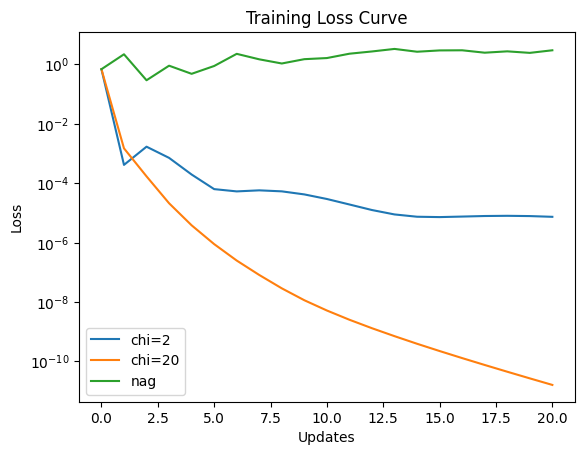

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# データ生成
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=42
)
y = y.reshape(-1, 1)  # ラベルを列ベクトルに変換
m = X.shape[0]  # サンプル数
epsilon = 1e-13

def compute_lipschitz_constant(X):
    # 各サンプルのノルムを計算し、その平方平均を求める
    lipschitz_constant = np.mean(np.linalg.norm(X, axis=1)**2)
    return lipschitz_constant

lipschitz_constant = compute_lipschitz_constant(X)
print(f"Lipschitz constant (L): {lipschitz_constant}")

# ロジスティック関数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 損失関数（クロスエントロピー損失）
def compute_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))

def compute_loss_with_bias(X, y, theta, bias):
    """
    バイアス項を考慮した損失関数
    """
    z = np.dot(X, theta) + bias  # バイアス項を加える
    predictions = sigmoid(z)
    loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    return loss

def find_optimal_theta(X, y):
    """
    バイアス項を考慮した最適化
    """
    n = X.shape[1]
    initial_theta = np.zeros(n)  # 初期のパラメータ
    initial_bias = 0.0  # バイアスの初期値

    # ラップ関数: minimizeに渡す
    def loss_fn(params):
        theta = params[:-1].reshape(-1, 1)  # 最後の要素を除いた部分を theta として扱う
        bias = params[-1]  # 最後の要素を bias として扱う
        return compute_loss_with_bias(X, y, theta, bias)

    # パラメータとバイアスを統合
    initial_params = np.concatenate([initial_theta.flatten(), [initial_bias]])

    # 最適化実行
    result = minimize(loss_fn, initial_params, method='BFGS', tol=1e-16)

    # 最適なパラメータを分離
    optimal_theta = result.x[:-1].reshape(-1, 1)  # theta
    optimal_bias = result.x[-1]  # bias
    all_preds = sigmoid(np.dot(X, optimal_theta) + optimal_bias)
    optimal_loss = compute_loss(y, all_preds)
    return optimal_theta, optimal_bias, optimal_loss

# 提案手法
def logistic_regression_nag_propose(X, y, L, max_updates, optimal_loss, chi):
    np.random.seed(42)
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, 1))
    bias = 0
    losses = []
    n_iterations = 10 ** 3
    v_weight = np.zeros((n_features, 1))
    v_bias = 0
    a_k_ = 1

    all_preds = sigmoid(np.dot(X, weights) + bias)
    loss = compute_loss(y, all_preds)

    losses.append(loss)
    print(f"Update init: Loss = {loss:.4f}")

    for update in range(max_updates):
      full_gradient = np.dot(X.T, sigmoid(np.dot(X, weights) + bias) - y) / m
      full_bias = (sigmoid(np.dot(X, weights) + bias) - y).mean()
      weights_pre = weights
      bias_pre = bias
      for iteration in range(n_iterations):
        # ランダムサンプリング
        random_index = np.random.randint(m)
        xi = X[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]

        a_k = a_k_
        a_k_ = a_k_ + ((iteration + 2) + update * n_iterations) ** (chi - 1)
        b_k = ( (a_k_ - a_k) * ((iteration  + update * n_iterations + 2 ) ** (1/2)) + ((L/2) * (a_k_ - a_k) ** 2) / a_k_ ) / 2

        z_weights = weights + ((a_k_ - a_k) / a_k_) * (v_weight - weights)
        z_bias = bias + ((a_k_ - a_k) / a_k_) * (v_bias - bias)

        # 予測値の計算
        linear_output = np.dot(xi, z_weights) + z_bias
        y_pred = sigmoid(linear_output)

        linear_output_pre = np.dot(xi, weights_pre) + bias_pre
        y_pred_pre = sigmoid(linear_output_pre)
        # 勾配の計算
        error = y_pred - yi
        error_pre = y_pred_pre - yi
        dw = np.dot(xi.T, error)
        db = error.mean()

        dw_pre = np.dot(xi.T, error_pre)
        db_pre = error_pre.mean()

        # パラメータの更新

        v_weight_ = v_weight - ((a_k_ - a_k) / (4 * b_k)) * (dw - dw_pre + full_gradient)
        v_bias_ = v_bias - ((a_k_ - a_k) / (4 * b_k)) * (db - db_pre + full_bias)
        weights_ = (a_k / a_k_) * weights + ( (a_k_ - a_k)/(a_k_)) * v_weight_
        bias_ = (a_k / a_k_) * bias + ( (a_k_ - a_k)/(a_k_)) * v_bias_

        v_weight = v_weight_
        v_bias = v_bias_
        bias = bias_
        weights = weights_
      all_preds = sigmoid(np.dot(X, weights) + bias)
      loss = compute_loss(y, all_preds)
      losses.append(abs(loss - optimal_loss))
      # print(f"Update {update}: Loss = {loss:.4f}")

    return weights, bias, losses
def logistic_regression_nag(X, y, L, max_updates, optimal_loss):
  np.random.seed(42)
  n_samples, n_features = X.shape
  weights = np.zeros((n_features, 1))
  bias = 0
  losses = []
  n_iterations = 10 ** 3
  v_weight = np.zeros((n_features, 1))
  v_bias = 0
  x_weight = np.zeros((n_features, 1))
  x_bias = 0
  z_weight = np.zeros((n_features, 1))
  z_bias = 0

  all_preds = sigmoid(np.dot(X, weights) + bias)
  loss = compute_loss(y, all_preds)

  losses.append(loss)
  # print(f"Update init: Loss = {loss:.4f}")

  for update in range(max_updates):
    full_gradient = np.dot(X.T, sigmoid(np.dot(X, weights) + bias) - y) / m
    full_bias = (sigmoid(np.dot(X, weights) + bias) - y).mean()
    weights_pre = weights
    bias_pre = bias
    for iteration in range(n_iterations):
      # ランダムサンプリング
      random_index = np.random.randint(m)
      xi = X[random_index:random_index + 1]
      yi = y[random_index:random_index + 1]
      a_k = 2 / (iteration + update * n_iterations + 2)
      L_k = (iteration + update * n_iterations) ** (1/2) + L
      x_weight = (1 - a_k) * weights + a_k * z_weight
      x_bias = (1 - a_k) * bias + a_k * z_bias

      # 予測値の計算
      linear_output = np.dot(xi, x_weight) + x_bias
      y_pred = sigmoid(linear_output)

      linear_output_pre = np.dot(xi, weights_pre) + bias_pre
      y_pred_pre = sigmoid(linear_output_pre)
      # 勾配の計算
      error = y_pred - yi
      error_pre = y_pred_pre - yi
      dw = np.dot(xi.T, error)
      db = error.mean()

      dw_pre = np.dot(xi.T, error_pre)
      db_pre = error_pre.mean()

      # パラメータの更新
      weights = x_weight -  (dw - dw_pre + full_gradient) / L_k
      bias = x_bias - (db - db_pre + full_bias) / L_k
      z_weight = z_weight - (x_weight - weights) / a_k
      z_bias = z_bias - (x_bias - bias) / a_k
    all_preds = sigmoid(np.dot(X, weights) + bias)
    loss = compute_loss(y, all_preds)
    losses.append(abs(loss - optimal_loss))
    # print(f"Update {update}: Loss = {loss:.4f}")
  return weights, bias, losses


optimal_theta, optimal_bias, optimal_loss = find_optimal_theta(X, y)
print(f"Optimal Loss (L*): {optimal_loss}")
# モデル訓練
weights, bias, losses = logistic_regression_nag_propose(X, y, lipschitz_constant, 20, optimal_loss, 2)
weights, bias, losses_ = logistic_regression_nag_propose(X, y, lipschitz_constant, 20, optimal_loss, 20)
weights, bias, losses_2 = logistic_regression_nag(X, y, lipschitz_constant, 20, optimal_loss)
# テストデータでの予測
linear_output = np.dot(X, weights) + bias
y_pred = sigmoid(linear_output)
y_pred_labels = (y_pred > 0.5).astype(int)

# 精度評価
accuracy = accuracy_score(y, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# 学習曲線のプロット
plt.plot(range(0, len(losses)), losses, label="chi=2")
plt.plot(range(0, len(losses_)), losses_, label="chi=20")
plt.plot(range(0, len(losses_2)), losses_2, label="nag")

plt.xlabel("Updates")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
ax = plt.gca()
# ax.set_ylim(1e-1, 1e+2)
ax.set_yscale("log")
plt.show()
